In [2]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath("../../"))
from dotenv import load_dotenv
load_dotenv()

True

**Table of contents**<a id='toc0_'></a>    
- [Intro](#toc1_)    
  - [Метрики данных](#toc1_1_)    
- [Сколько всего презентаций](#toc2_)    
- [Сколько слайдов в презентациях](#toc3_)    
- [Разрешения](#toc4_)    
  - [Разрешения не всегда инты](#toc4_1_)    
  - [Стандарт 16/9. Цена типичного слайда](#toc4_2_)    
  - [Какие разрешения в разных датасетах](#toc4_3_)    
  - [Совпадают ли разрешения для всех слайдов в презентации?](#toc4_4_)    
- [Сколько платить за разметку](#toc5_)    
- [Сколько текста в презентациях](#toc6_)    
- [Сколько картинок в презентациях](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Intro](#toc0_)
Проект про создание поисковика по презентациям. Хочется искать по текстовому и визуальному контенту. 

Идея:
- gpt-4-vision описывает слайды (текст, картинки, графики)
- описания векторизуются и кладутся в векторную БД (ChromaDB)
- запрос от пользователя тоже векторизуется и из базы достаются самые "близкие" элементы

Данные - датасет презентаций. 

Темы и источники: 
- **data-science** 
  - конференция AIConf 2024
  - конференция YappiDays 2024

Это в основном презентации к выступлению. В них мало текста, много картинок, много слайдов 


- **business**
  - тг-канал business_incognita
  - тг-канал insider_infor

Это скорее презентации для чтения. В них больше текста на слайдах. Слайды в основном содержат много информации, но их общее количество меньше.

[Ссылка на гугл-диск с презентациями](https://drive.google.com/drive/folders/19tWNjEEhALCxfmFeXEcwwRfxjyc1EStf?usp=sharing)


## <a id='toc1_1_'></a>[Метрики данных](#toc0_)
- Распределение количества слайдов в презентациях
- Разрешения документов
- Цены на токены - не является метрикой, но тоже часть проекта
- Распределение количества текста на слайдах
- Распределение количества картинок на слайдах

# <a id='toc2_'></a>[Сколько всего презентаций](#toc0_)

In [3]:
from src import Config
from src.eda import parse_pdf_directory

config = Config()

df = parse_pdf_directory(config.navigator.raw, exclude_datasets=["weird-slides"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       84 non-null     object 
 1   relative_path  84 non-null     object 
 2   topic          84 non-null     object 
 3   dataset        84 non-null     object 
 4   nav            84 non-null     object 
 5   num_pages      84 non-null     int64  
 6   total_images   84 non-null     int64  
 7   total_n_words  84 non-null     int64  
 8   page_width     84 non-null     float64
 9   page_height    84 non-null     float64
 10  varying_sizes  84 non-null     object 
dtypes: float64(2), int64(3), object(6)
memory usage: 7.3+ KB


In [11]:
count_pres = (
    df.groupby(["dataset", "topic"])
    .aggregate(
        n_pres=("filename", "count"),
    )
    .sort_values(["n_pres", "topic"], ascending=False)
    .reset_index()
)
count_pres

,dataset,topic,n_pres
0,aiconf,data-science,50
1,yappi-days,data-science,19
2,insider_infor,business,10
3,business_incognita,business,5


# <a id='toc3_'></a>[Сколько слайдов в презентациях](#toc0_)


In [11]:
pages_count = (
    df
    .groupby("topic")
    .aggregate(
        total_presentations=("num_pages", "count"),
        total_slides=("num_pages", "sum"),
    )
    .reset_index()
)
pages_count

,topic,total_presentations,total_slides
0,business,15,410
1,data-science,69,3604


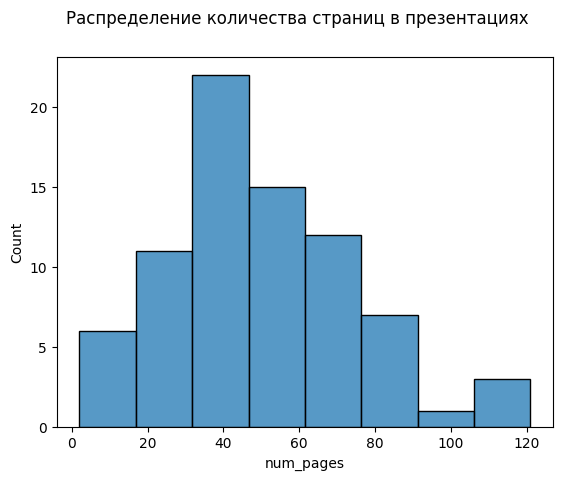

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.histplot(df, x='num_pages')
g = g.figure.suptitle("Распределение количества страниц в презентациях")

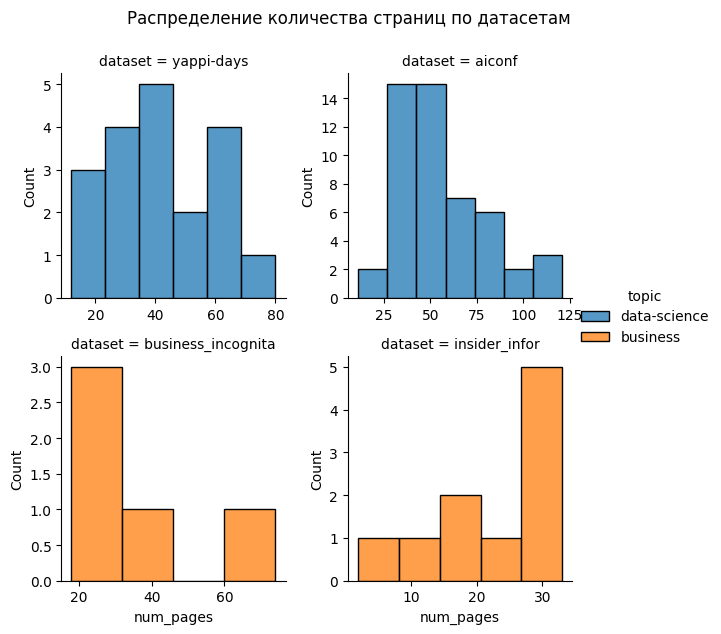

In [75]:
g = sns.FacetGrid(df, col="dataset", hue="topic", col_wrap=2, sharex=False, sharey=False)
g.map(sns.histplot, "num_pages")
g.figure.suptitle("Распределение количества страниц по датасетам", y=1.05)
g.add_legend()
plt.show()

# <a id='toc4_'></a>[Разрешения](#toc0_)

Разрешение - пара (width, height) - количество пикселей, которые приходятся на ширину/высоту.

Есть несколько причин смотреть на разрешение документов при работе с презентациями: 
1. Фильтр "не презентаций". У презентаций ширина больше высоты. Если наоборот, то это скорее книга/документ. Могут быть вертикальные презентации, но редко.
2. Размер файла на диске. Больше пикселей - больше размер. \
   Для моих задач не нужны ultra-high-res презентации - достаточно стандартных 960х540. Презентации с высоким разрешением можно сжать.

## <a id='toc4_1_'></a>[Разрешения не всегда инты](#toc0_)

In [62]:
resolutions = (
    df.assign(
        resolution=lambda df_: list(df_[['page_width', 'page_height']].itertuples(index=False, name=None))
    )
    .groupby("resolution")
    .aggregate(
        count=("resolution", "count")
    )
    .sort_values("count", ascending=False)
    .reset_index()
)
resolutions

,resolution,count
0,"(960.0, 540.0)",41
1,"(720.0, 405.0)",10
2,"(1920.0, 1080.0)",7
3,"(1919.8800048828125, 1080.0)",4
4,"(1440.0, 810.0)",3
5,"(1559.0400390625, 878.760009765625)",3
6,"(1919.0, 1080.0)",2
7,"(453.5429992675781, 255.1179962158203)",1
8,"(595.3200073242188, 841.9199829101562)",1
9,"(780.0, 540.0)",1


Не все они инты.

## <a id='toc4_2_'></a>[Стандарт 16/9. Цена типичного слайда](#toc0_)
Я округлил разрешения до 10 и посчитал aspect. Результаты и выводы ниже

In [63]:
from fractions import Fraction
from src.eda import calculate_image_tokens, tokens2price

openai_1k_token_price = 0.00015 # https://openai.com/api/pricing/
prompt_tokens = 3500

df_int_res = (
    df.assign(
        # Round resolutions to 10
        resolution=lambda df_: (
            list(df_[['page_width', 'page_height']]
            .astype(int).round(-1)
            .itertuples(index=False, name=None))
        ),

        # Calculate aspect
        aspect=lambda df_: (
            df_["resolution"]
            .apply(lambda x: Fraction(x[0], x[1]) )
        ),

        # Vision tokens
        page_vision_tokens=lambda df_: (
            df_["resolution"]
            .apply(lambda x: calculate_image_tokens(*x))
        ),

        # Vision tokens for mini are x33
        page_vision_tokens_mini=lambda df_: df_["page_vision_tokens"] * 33,

        # Add system tokens
        page_total_tokens = lambda df_: (
            df_["page_vision_tokens_mini"] + prompt_tokens
        ),

        # Page cost
        page_cost=lambda df_: (
            df_["page_total_tokens"]
            .apply(lambda x: tokens2price(x, openai_1k_token_price))
        ),

        # Total tokens per presentation
        pres_total_tokens = lambda df_: df_["page_total_tokens"] * df_["num_pages"],

        # Tokens for openai
        pres_total_cost=lambda df_: (
            df_["page_cost"] * df_["num_pages"]
        )
    )
)

resolutions = (
    df_int_res
    .groupby(["resolution", "aspect"])
    .aggregate(
        pres_count=("resolution", "count"),
        page_tokens=("page_vision_tokens", "first"),
    )
    .sort_values("pres_count", ascending=False)
    .reset_index()
)
resolutions

,resolution,aspect,pres_count,page_tokens
0,"(960, 540)",16/9,42,765
1,"(1920, 1080)",16/9,14,1105
2,"(720, 400)",9/5,10,425
3,"(1560, 880)",39/22,4,1105
4,"(1440, 810)",16/9,3,1105
5,"(450, 260)",45/26,1,255
6,"(600, 840)",5/7,1,765
7,"(780, 540)",13/9,1,765
8,"(1220, 790)",122/79,1,1105


- Преобладает дефолтое разрешение PowerPoint: 960x540 (16/9)
- Есть 1920x1080. В принципе, их можно уменьшать в два раза, чтобы сэкономить на токенах.

Посмотрим, сколько они будут стоить:

In [64]:
resolutions_costs = (
    df_int_res
    .groupby(["resolution", "aspect"])
    .aggregate(
        pres_count=("resolution", "count"),
        page_cost=("page_cost", lambda df_: df_.iloc[0].round(4)),
        pages_count=("num_pages", "sum"),
        total_cost=("pres_total_cost", lambda df_: df_.sum().round(2)),
    )
    .sort_values("pres_count", ascending=False)
    .reset_index()
)
resolutions_costs

,resolution,aspect,pres_count,page_cost,pages_count,total_cost
0,"(960, 540)",16/9,42,0.0043,2179,9.40
1,"(1920, 1080)",16/9,14,0.0060,701,4.20
2,"(720, 400)",9/5,10,0.0026,429,1.13
3,"(1560, 880)",39/22,4,0.0060,257,1.54
4,"(1440, 810)",16/9,3,0.0060,111,0.67
5,"(450, 260)",45/26,1,0.0018,86,0.15
6,"(600, 840)",5/7,1,0.0043,2,0.01
7,"(780, 540)",13/9,1,0.0043,20,0.09
8,"(1220, 790)",122/79,1,0.0060,39,0.23


## <a id='toc4_3_'></a>[Какие разрешения в разных датасетах](#toc0_)
Та же таблица, но с датасетами

In [65]:
resolutions = (
    df_int_res
    .apply(lambda x: x)
    .groupby(["resolution", "aspect", "dataset"])
    .aggregate(
        count=("resolution", "count")
    )
    .sort_values("count", ascending=False)
    .reset_index()
)
resolutions

,resolution,aspect,dataset,count
0,"(960, 540)",16/9,aiconf,31
1,"(1920, 1080)",16/9,aiconf,9
2,"(720, 400)",9/5,aiconf,6
3,"(960, 540)",16/9,yappi-days,6
4,"(1920, 1080)",16/9,yappi-days,5
5,"(720, 400)",9/5,yappi-days,4
6,"(960, 540)",16/9,insider_infor,4
7,"(1440, 810)",16/9,yappi-days,3
8,"(1560, 880)",39/22,aiconf,3
9,"(450, 260)",45/26,aiconf,1


## <a id='toc4_4_'></a>[Совпадают ли разрешения для всех слайдов в презентации?](#toc0_)
Нашлась презентация, у которой первый слайд вертикальный, а остальные горизонтальные. 
[Ссылка на Accenture x UN_GenAI](https://drive.google.com/file/d/1Z9_7ZDOqdYGO1qgiDzsDRxQDPIRm4Jrn/view?usp=sharing)

У другой различие на 1 пиксель - можно не считать

In [ ]:
df[~df["varying_sizes"].eq("")][["filename", "topic", "dataset", "varying_sizes"]]

,filename,topic,dataset,varying_sizes
14,1. Маевский - OSINT лекция.pdf,data-science,yappi-days,"{(959.0, 540.0), (960.0, 540.0)}"
69,Accenture x UN_GenAI For Global Goals_2024 (39...,business,business_incognita,"{(612.0, 792.0), (1224.0, 792.0)}"


# <a id='toc5_'></a>[Сколько платить за разметку](#toc0_)

Расчет в соответствии с [гайдом от openai](https://platform.openai.com/docs/guides/vision#calculating-costs)

In [58]:
price = (
    df_int_res
    .groupby("topic")
    .aggregate(
        total_presentations=("title", "count"),
        total_slides=("num_pages", "sum"),
        total_tokens=("pres_total_tokens", "sum"),
        total_cost_usd=("pres_total_cost", "sum")
    )
    .reset_index()
    .assign(
        total_tokens=lambda df_: (
            df_["total_tokens"]
            .apply(lambda x: f"{x:.2e}" )
        ),
        total_cost_usd=lambda df_: (
            df_["total_cost_usd"]
            .round(2)
        )
    )
    .sort_values("total_cost_usd", ascending=False)
)
price

,topic,total_presentations,total_slides,total_tokens,total_cost_usd
1,data-science,69,3604,1.09e+08,16.40
0,business,8,220,6.76e+06,1.01


# <a id='toc6_'></a>[Сколько текста в презентациях](#toc0_)

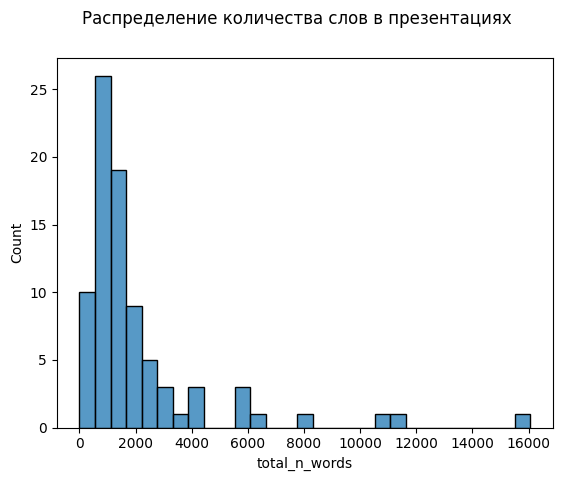

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

df_text = (
    df.assign(
        n_words_slide = df["total_n_words"] / df["num_pages"]
    )
)
g = sns.histplot(df, x='total_n_words')
g = g.figure.suptitle("Распределение количества слов в презентациях")


In [74]:
df_text.query("total_n_words > 10000")

,filename,relative_path,topic,dataset,nav,num_pages,total_images,total_n_words,page_width,page_height,varying_sizes,n_words_slide
69,Accenture x UN_GenAI For Global Goals_2024 (39...,business/business_incognita/Accenture x UN_Gen...,business,business_incognita,,39,67,16062,1224.0,792.0,"{(612.0, 792.0), (1224.0, 792.0)}",411.846154
73,SP_Навигатор_по_мерам_гос_поддержки_2024_74_ст...,business/business_incognita/SP_Навигатор_по_ме...,business,business_incognita,,74,296,11275,960.0,540.0,,152.364865
80,Kept_Обзор_цен_в_металлургической_отрасли_2К20...,business/insider_infor/Kept_Обзор_цен_в_металл...,business,insider_infor,,33,22,10810,780.0,540.0,,327.575758


В них правда много текста - это скорее презентации для чтения, чем для выступления. 

[Ссылка на Accenture x UN_GenAI](https://drive.google.com/file/d/1Z9_7ZDOqdYGO1qgiDzsDRxQDPIRm4Jrn/view?usp=sharing)

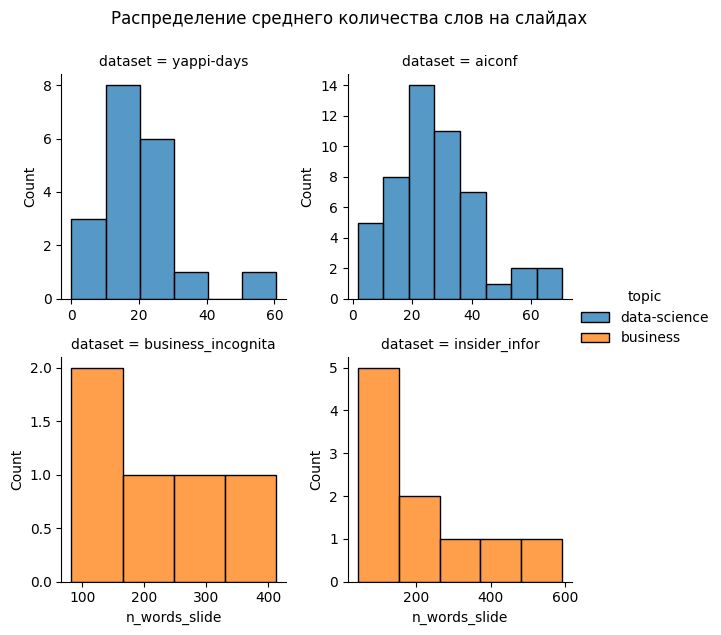

In [55]:
g = sns.FacetGrid(df_text, col="dataset", hue="topic", col_wrap=2, sharex=False, sharey=False)
g.map(sns.histplot, "n_words_slide")
g.figure.suptitle("Распределение среднего количества слов на слайдах", y=1.05)
g.add_legend()
plt.show()

Видим, что в бизнес-презентациях больше слов. У них такой формат - презентации для чтения. Презентации по DS более про иллюстрации к выступлению.

# <a id='toc7_'></a>[Сколько картинок в презентациях](#toc0_)

Количество картинок берется из парсера `pymupdf`. 

Недостатки такого подхода: 
- Можем принять стиль презентации за картинку 
- Один визуальный элемент может быть составлен из нескольких картинок. Например, составная диаграмма
- Если автор вставил таблицу скриншотом, то она будет посчитана как картинка

Но все равно он дает информацию о наполении презентаций картинками. Ее можно использовать для сравнения датасетов.

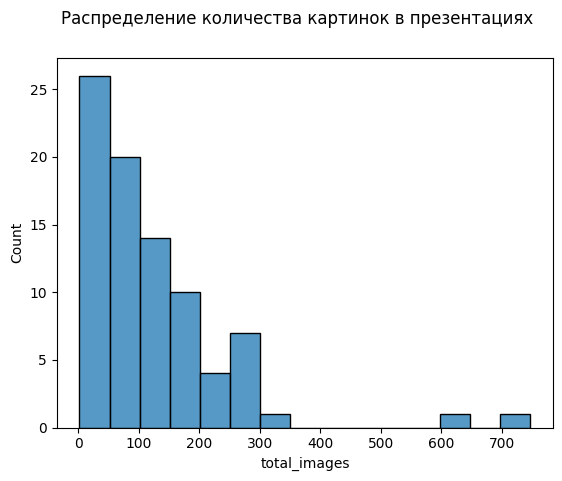

In [70]:
df_img = (
    df.assign(
        n_images_slide = df["total_images"] / df["num_pages"]
    )
)
g = sns.histplot(df, x='total_images')
g = g.figure.suptitle("Распределение количества картинок в презентациях")

In [19]:
df.query("total_images > 500")

,filename,relative_path,topic,dataset,nav,num_pages,total_images,total_text_length,page_width,page_height,varying_sizes
25,4.Где и как использовать LLM в задачах поиска_...,data-science/aiconf/День2/3.Аудитория 1/4.Где ...,data-science,aiconf,День2/3.Аудитория 1,31,747,52,960.0,540.0,
64,6.LLM говорит мультимодальные задачи в речевом...,data-science/aiconf/День1/2.Полусфера/6.LLM го...,data-science,aiconf,День1/2.Полусфера,45,632,307,960.0,540.0,


В этих презентациях много схем, иллюстраций. Каждая маленькая картинка засчитывается за отдельную. Поэтому их столько

[Ссылка на "4.Где и как использовать LLM в задачах поиска_"](https://drive.google.com/file/d/12c-JPrb7QTaRNLCrn8QnXMDj4CNIl62u/view?usp=sharing)

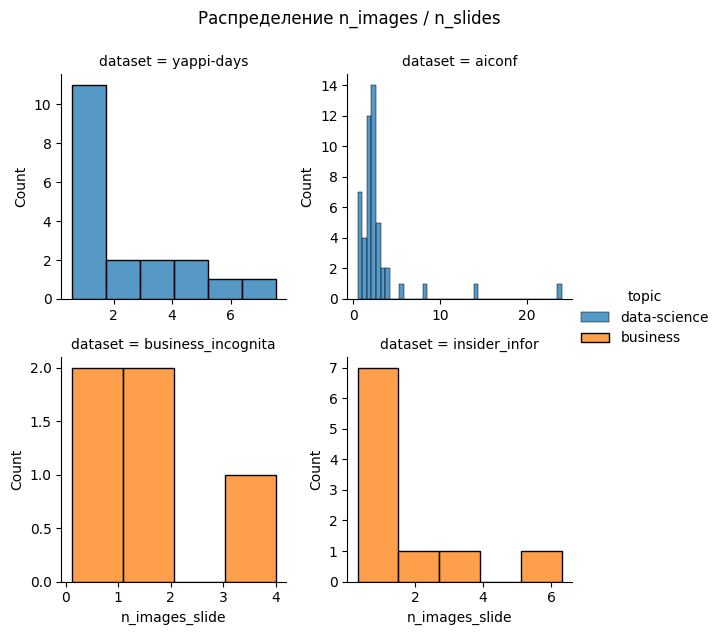

In [69]:
g = sns.FacetGrid(df_img, col="dataset", hue="topic", col_wrap=2, sharex=False, sharey=False)
g.map(sns.histplot, "n_images_slide")
g.figure.suptitle("Распределение n_images / n_slides", y=1.05)
g.add_legend()
plt.show()

Видим, что количество картинок примерно одинаковое